In [ ]:
%cd /content/drive/MyDrive/Home_Depot_Case_Study/Workspace3
!pwd

/content/drive/MyDrive/Home_Depot_Case_Study/Workspace3
/content/drive/MyDrive/Home_Depot_Case_Study/Workspace3


# Imports and Utility Functions

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib_venn import venn2
import regex as re
from collections import Counter
!pip install nltk 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from collections import Counter
from nltk.stem import PorterStemmer 
from wordcloud import WordCloud, STOPWORDS 
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer 
from textblob import TextBlob
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import math
import re
import xgboost as xgb
from xgboost import XGBRegressor
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm
import pickle
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint, loguniform
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Utility Functions
def display_results(results, thresh=0.1):
  ranks = results.cv_results_['rank_test_score']
  ind = np.argsort(ranks)
  sorted_train_scores = np.array(-results.cv_results_['mean_train_score'])[ind]
  sorted_test_scores = np.array(-results.cv_results_['mean_test_score'])[ind]
  sorted_params = np.array(results.cv_results_['params'])[ind]
  
  for i in range(len(ranks)):
    if (sorted_test_scores[i] - sorted_train_scores[i]) < thresh:
      print('train ->', sorted_train_scores[i])
      print('test ->', sorted_test_scores[i])
      print('params ->', sorted_params[i])
      print('*'*100)
    else: 
      continue

def plot_scores_single(results, param, log=False):
  '''
  Here you can use continuous distribution also for the single parameter
  '''
  X = [x[param] for x in results.cv_results_['params']]
  if log:
    X = [math.log10(a) for a in X]
  plt.plot(X, -results.cv_results_['mean_train_score'])
  plt.plot(X, -results.cv_results_['mean_test_score'])
  plt.title('rmse')
  plt.ylabel('rmse')
  plt.xlabel(param)
  plt.legend(['train', 'tets'], loc='lower left')
  plt.show()

# Preparing the Data

* Total Data is divided 80-20 and stored in Train_X, Train_Y, Test_X, Test_Y
* train data Train_X is split further 50-50 into Train_X1, Train_Y1, Train_X2, Train_Y2
* The data Train_X1, Train_Y1 is used for training each base models. 
* Train_X2, Train_Y2 is then used to train the meta classifier 
* For splitting into train and test (80-20) we have used train_test_split and then we always use random_state=122
* For sampling we use, df.sample(). The sample datasets are succeeded with the characted S. So the first sample data is stored in X1_train_S1 with random state=101. The second in X2_train_S2 with random state 102 and so on the pattern is continued. 

**Features contain 900 w2v features + 71 numerical features** 


In [ ]:
data1_train = pd.read_pickle('featurization/train/feature_set1/data1_train.pkl')
data1_train_comb = pd.read_pickle('featurization/train/feature_set1/data1_train_comb.pkl')
data2_train = pd.read_pickle('featurization/train/feature_set2/data2_train.pkl')
data3_train = pd.read_pickle('featurization/train/feature_set3/data3_train.pkl')
tfidf_w2v_df_train = pd.read_pickle('featurization/train/feature_set3/tfidf_w2v_df_train.pkl')
print(data1_train_comb.shape, data2_train.shape, data3_train.shape, tfidf_w2v_df_train.shape)

Train_X = pd.concat([data1_train_comb, data2_train, data3_train, tfidf_w2v_df_train], axis=1)
Train_Y = data1_train['relevance']
print(Train_X.shape, Train_Y.shape)

(59253, 29) (59253, 3) (59253, 39) (59253, 900)
(59253, 971) (59253,)


In [ ]:
data1_test = pd.read_pickle('featurization/test/feature_set1/data1_test.pkl')
data1_test_comb = pd.read_pickle('featurization/test/feature_set1/data1_test_comb.pkl')
data2_test = pd.read_pickle('featurization/test/feature_set2/data2_test.pkl')
data3_test = pd.read_pickle('featurization/test/feature_set3/data3_test.pkl')
tfidf_w2v_df_test = pd.read_pickle('featurization/test/feature_set3/tfidf_w2v_df_test.pkl')
print(data1_test_comb.shape, data2_test.shape, data3_test.shape, tfidf_w2v_df_test.shape)

Test_X = pd.concat([data1_test_comb, data2_test, data3_test, tfidf_w2v_df_test], axis=1)
Test_Y = data1_test['relevance']
print(Test_X.shape, Test_Y.shape)

(14814, 29) (14814, 3) (14814, 39) (14814, 900)
(14814, 971) (14814,)


In [ ]:
Test_Y.to_pickle('meta_model/Test_Y.pkl')

**Splitting the train data into 50-50 for the stacking regressor**

In [ ]:
#To cross verify, the indices should be [74039, 69439, 44373, 27105, 52547] and [43774, 47798, 38472, 15349, 41981]
Train_X1, Train_X2, Train_Y1, Train_Y2 = train_test_split(Train_X, Train_Y, test_size=0.5, stratify=data1_train['relevance_class'], random_state = 122)

print(Train_X1.shape, Train_Y1.shape)
print(Train_X2.shape, Train_Y2.shape)

(29626, 971) (29626,)
(29627, 971) (29627,)


# Base Models

## 1. SVR

In [ ]:
X_train_S1 = Train_X1.sample(frac=0.85, random_state=101, axis=0)
y_train_S1 = Train_Y1.sample(frac=0.85, random_state=101, axis=0)

print(X_train_S1.shape, y_train_S1.shape)

(25182, 971) (25182,)


In [ ]:
scaler = StandardScaler()
X_std1 = scaler.fit_transform(X_train_S1)

In [ ]:
# random_grid = {
#                'C': [0.1, 0.2, 0.3],
#                #'gamma': [0.01, 0.1]
#                }

# model = SVR()
# random_search = RandomizedSearchCV(estimator = model, 
#                                param_distributions = random_grid, n_iter = 20, 
#                                scoring='neg_root_mean_squared_error', 
#                                cv = 3, verbose=100, return_train_score=True, 
#                                random_state=42, n_jobs = -1)
# results = random_search.fit(X_std1, y_train_S1)
# # summarize
# best_ind = results.best_index_
# print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
# print('Config: %s' % results.best_params_)

**FINAL MODEL TRAINING AND SAVING**
* best_params = C : 0.1

In [ ]:
best_params = {'C': 0.1}

scaler_svr = StandardScaler()
X_std1 = scaler_svr.fit_transform(X_train_S1)

svr_model = SVR(**best_params)
svr_model.fit(X_std1, y_train_S1)

pickle.dump(scaler_svr, open('base_models/F2_scaler_svr.pkl', "wb"))
pickle.dump(svr_model, open('base_models/F2_svr.pkl', "wb"))

## 2. Random Forest Regressor

In [ ]:
X_train_S2 = Train_X1.sample(frac=0.85, random_state=102, axis=0)
y_train_S2 = Train_Y1.sample(frac=0.85, random_state=102, axis=0)

print(X_train_S2.shape, y_train_S2.shape)
print('number of unique datapoints', len(set(X_train_S2.index)))

(25182, 971) (25182,)
number of unique datapoints 25182


In [ ]:
random_grid = {
               #'bootstrap': [True],
               #'max_depth': randint(6,11), 
               #'max_features': uniform(0.2, 0.6), 
               #'min_samples_leaf': randint(2, 100),
               #'n_estimators': 50
               }

model = RandomForestRegressor(max_features=0.8, min_samples_leaf=20, min_samples_split=2, n_estimators=50, max_depth=10)
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 30, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=20, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_train_S2, y_train_S2)
# summarize
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][results.best_index_])
print('best params', results.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  7.3min finished


best rmse: test 0.4693437555675077 train 0.39482280231427674
best params {}


**FINAL MODEL TRAINING AND SAVING**

* best params {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 20}

In [ ]:
best_params = {'bootstrap':True, 
               'min_samples_leaf': 20, 
               'max_features': 0.8, 
               'max_depth': 10, 
               'n_estimators': 100}

rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train_S2, y_train_S2)

pickle.dump(rf_model, open('base_models/F2_rf.pkl', "wb"))

In [ ]:
y_pred = rf_model.predict(X_train_S2)
mean_squared_error(y_train_S2, y_pred, squared=False)

0.40265529607003614

## 3. Ridge Regression

In [ ]:
X_train_S3 = Train_X1.sample(frac=0.85, random_state=103, axis=0)
y_train_S3 = Train_Y1.sample(frac=0.85, random_state=103, axis=0)

print(X_train_S3.shape, y_train_S3.shape)
print('number of unique datapoints', len(set(X_train_S3.index)))

(25182, 971) (25182,)
number of unique datapoints 25182


In [ ]:
scaler = StandardScaler()
X_std3 = scaler.fit_transform(X_train_S3)

best rmse: test 0.4748437637818233 train 0.4609763595973633
best param {'alpha': 5611.516415334504}


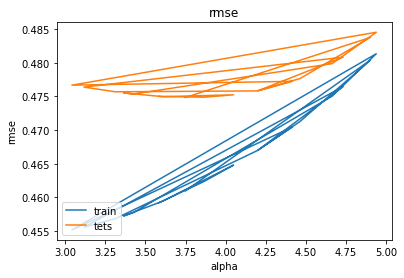

In [ ]:
random_grid = {
               'alpha': loguniform(1e3, 1e5)
               }

model = Ridge()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 20, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=False, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std3, y_train_S3)
# summarize
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][results.best_index_])
print('best param', results.best_params_)

plot_scores_single(results, 'alpha', log=True)

**FINAL MODEL TRAINING AND SAVING**

* best param {'alpha': 5611.024758370766}


In [ ]:
best_params = {'alpha':5611}

scaler_ridge = StandardScaler()
X_std3 = scaler_ridge.fit_transform(X_train_S3)

ridge_model = Ridge(**best_params)
ridge_model.fit(X_std3, y_train_S3)

pickle.dump(scaler_ridge, open('base_models/F2_scaler_ridge.pkl', "wb"))
pickle.dump(ridge_model, open('base_models/F2_ridge.pkl', "wb"))

## 4. Lasso Regression

In [ ]:
X_train_S4 = Train_X1.sample(frac=0.85, random_state=104, axis=0)
y_train_S4 = Train_Y1.sample(frac=0.85, random_state=104, axis=0)

print(X_train_S4.shape, y_train_S4.shape)
print('number of unique datapoints', len(set(X_train_S4.index)))

(25182, 971) (25182,)
number of unique datapoints 25182


In [ ]:
scaler = StandardScaler()
X_std4 = scaler.fit_transform(X_train_S4)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.7min remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


best rmse: test 0.4749934612700712 train 0.46528155530967713
best params {'alpha': 0.002910635913133069}


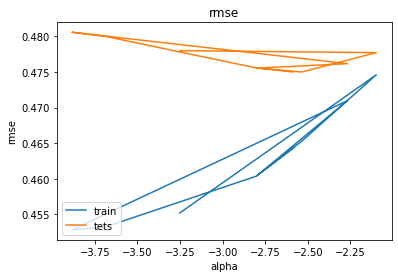

In [ ]:
random_grid = {
               'alpha': loguniform(1e-4, 1e-2)
               }

model = Lasso()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 10, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=10, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std4, y_train_S4)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('best params', results.best_params_)

plot_scores_single(results, 'alpha', log=True)

**FINAL MODEL TRAINING AND SAVING**

* best param {'alpha': 0.0029}



In [ ]:
best_params = {'alpha': 0.0029}

scaler_lasso = StandardScaler()
X_std4 = scaler_lasso.fit_transform(X_train_S4)

lasso_model = Lasso(**best_params)
lasso_model.fit(X_std4, y_train_S4)

pickle.dump(scaler_lasso, open('base_models/F2_scaler_lasso.pkl', "wb"))
pickle.dump(lasso_model, open('base_models/F2_lasso.pkl', "wb"))

## 5. Elastic Net Regression

In [ ]:
X_train_S5 = Train_X1.sample(frac=0.85, random_state=105, axis=0)
y_train_S5 = Train_Y1.sample(frac=0.85, random_state=105, axis=0)

print(X_train_S5.shape, y_train_S5.shape)
print('number of unique datapoints', len(set(X_train_S5.index)))

(25182, 971) (25182,)
number of unique datapoints 25182


In [ ]:
scaler = StandardScaler()
X_std5 = scaler.fit_transform(X_train_S5)

In [ ]:
random_grid = {
               'alpha': loguniform(1e-5, 1e2),
               'l1_ratio': uniform(0,1)
               }

model = ElasticNet()
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 30, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=10, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_std5, y_train_S5)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('best param', results.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.2min finished


best rmse: test 0.47323032011964594 train 0.46398490014316085
best param {'alpha': 0.010558813779064832, 'l1_ratio': 0.2912291401980419}


**FINAL MODEL TRAINING AND SAVING**

* best param {'alpha': 0.010558, 'l1_ratio': 0.2912}

In [ ]:
best_params = {'alpha': 0.010558, 'l1_ratio': 0.2912}

scaler_en = StandardScaler()
X_std5 = scaler_en.fit_transform(X_train_S5)

en_model = ElasticNet(**best_params)
en_model.fit(X_std5, y_train_S5)

pickle.dump(scaler_en, open('base_models/F2_scaler_en.pkl', "wb"))
pickle.dump(en_model, open('base_models/F2_en.pkl', "wb"))

## 6. Shallow Neural Netork 

In [ ]:
# X_train_S6 = Train_X1.sample(frac=0.85, random_state=106, axis=0)
# y_train_S6 = Train_Y1.sample(frac=0.85, random_state=106, axis=0)

# print(X_train_S6.shape, y_train_S6.shape)
# print('number of unique datapoints', len(set(X_train_S6.index)))

In [ ]:
# scaler = StandardScaler()
# X_std6 = scaler.fit_transform(X_train_S6)

In [ ]:
# model1 = Sequential()
# model1.add(Dense(4, activation='relu', input_dim=X_std6.shape[1]))
# model1.add(Dropout(0.2))
# model1.add(Dense(1, activation='relu'))
# model1.compile(optimizer='adam',
#               loss='mse',
#               metrics=[RootMeanSquaredError()])

# history = model1.fit(X_std6, y_train_S6, batch_size=32, verbose=2, epochs=500, validation_split=0.3)

In [ ]:
# scaler_nn = StandardScaler()
# X_std6 = scaler_nn.fit_transform(X_train_S6)

# nn_model = model1
# nn_model.fit(X_std6, y_train_S6, batch_size=32, epochs=best_epochs)

# pickle.dump(scaler_nn, open('base_models/F2_scaler_nn.pkl', "wb"))
# pickle.dump(nn_model, open('base_models/F2_nn.pkl', "wb"))

## 7. Decision Tree Regressor

In [ ]:
X_train_S7 = Train_X1.sample(frac=0.85, random_state=107, axis=0)
y_train_S7 = Train_Y1.sample(frac=0.85, random_state=107, axis=0)

print(X_train_S7.shape, y_train_S7.shape)
print('number of unique datapoints', len(set(X_train_S7.index)))

(25182, 971) (25182,)
number of unique datapoints 25182


In [ ]:
random_grid = {
               #'criterion' : ['mse', 'mae'],
               'max_depth' : randint(3, 30),
               'max_features' : uniform(0,1),
               'min_samples_leaf' : [2, 10, 20, 50, 100, 200, 400, 1000]
               }

model = DecisionTreeRegressor(criterion='mse', min_samples_leaf=2, max_depth=10)
random_search = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, n_iter = 30, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 3, verbose=20, return_train_score=True, 
                               random_state=42, n_jobs = -1)
results = random_search.fit(X_train_S7, y_train_S7)
# summarize
best_ind = results.best_index_
print('best rmse:', 'test', -results.best_score_, 'train', -results.cv_results_['mean_train_score'][best_ind])
print('best params', results.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

best rmse: test 0.48160240936283194 train 0.47056200886293215
best params {'max_depth': 6, 'max_features': 0.9422017556848528, 'min_samples_leaf': 200}


**FINAL MODEL TRAINING AND SAVING**

* best_params = {critetion : 'mse', 'max_depth': 6, 'max_features': 0.942, 'min_samples_leaf': 200}

In [ ]:
best_params = {'criterion': 'mse', 'max_depth': 6, 'max_features': 0.942, 'min_samples_leaf': 200}

dt_model = DecisionTreeRegressor(**best_params)
dt_model.fit(X_train_S7, y_train_S7)

pickle.dump(dt_model, open('base_models/F2_dt.pkl', "wb"))

# Dataset for Meta Classifier

**LOADING THE MODELS**

In [ ]:
#Loading the standard scalers
F2_scaler_ridge = pickle.load(open('base_models/F2_scaler_ridge.pkl', 'rb'))
F2_scaler_lasso = pickle.load(open('base_models/F2_scaler_lasso.pkl', 'rb'))
F2_scaler_en = pickle.load(open('base_models/F2_scaler_en.pkl', 'rb'))
F2_scaler_svr = pickle.load(open('base_models/F2_scaler_svr.pkl', 'rb'))

#Loading the models 
F2_svr = pickle.load(open('base_models/F2_svr.pkl', 'rb'))
F2_rf = pickle.load(open('base_models/F2_rf.pkl', 'rb'))
F2_ridge = pickle.load(open('base_models/F2_ridge.pkl', 'rb'))
F2_lasso = pickle.load(open('base_models/F2_lasso.pkl', 'rb'))
F2_en = pickle.load(open('base_models/F2_en.pkl', 'rb'))
F2_dt = pickle.load(open('base_models/F2_dt.pkl', 'rb'))

**TRAIN DATA**

In [ ]:
pred_svr = F2_svr.predict(F2_scaler_svr.transform(Train_X2)) 
pred_rf = F2_rf.predict(Train_X2) 
pred_ridge = F2_ridge.predict(F2_scaler_ridge.transform(Train_X2)) 
pred_lasso = F2_lasso.predict(F2_scaler_lasso.transform(Train_X2)) 
pred_en = F2_en.predict(F2_scaler_en.transform(Train_X2)) 
pred_dt = F2_dt.predict(Train_X2) 

In [ ]:
arr = np.hstack((pred_svr.reshape(-1,1),
                 pred_rf.reshape(-1,1),                                    
                 pred_ridge.reshape(-1,1),
                 pred_lasso.reshape(-1,1), 
                 pred_en.reshape(-1,1),
                 pred_dt.reshape(-1,1),))

F2_df = pd.DataFrame(arr, columns=['f2_svr', 'f2_rf', 'f2_ridge', 'f2_lasso', 'f2_en', 'f2_dt'], index=Train_X2.index)
F2_df.to_pickle('meta_model/Train_X2_F2.pkl')

**TEST DATA**

In [ ]:
pred_svr = F2_svr.predict(F2_scaler_svr.transform(Test_X)) 
pred_rf = F2_rf.predict(Test_X) 
pred_ridge = F2_ridge.predict(F2_scaler_ridge.transform(Test_X)) 
pred_lasso = F2_lasso.predict(F2_scaler_lasso.transform(Test_X)) 
pred_en = F2_en.predict(F2_scaler_en.transform(Test_X)) 
pred_dt = F2_dt.predict(Test_X) 

In [ ]:
arr = np.hstack((pred_svr.reshape(-1,1),
                 pred_rf.reshape(-1,1),                                    
                 pred_ridge.reshape(-1,1),
                 pred_lasso.reshape(-1,1), 
                 pred_en.reshape(-1,1),
                 pred_dt.reshape(-1,1),))

F2_df = pd.DataFrame(arr, columns=['f2_svr', 'f2_rf', 'f2_ridge', 'f2_lasso', 'f2_en', 'f2_dt'], index=Test_X.index)
F2_df.to_pickle('meta_model/Test_X_F2.pkl')